In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from openbb import obb
from scipy.stats import spearmanr

In [5]:
obb.user.preferences.output_type = "dataframe"

In [9]:
# load data
symbols = ["NEM", "RGLD", "SSRM", "CDE", "LLY", "UNH", "JNJ", "MRK"]

data = obb.equity.price.historical(
    symbols,
    start_date="2017-01-01",
    end_date="2024-12-31",
    provider="yfinance"
)

prices = data[["high", "low", "close", "volume", "symbol"]]

In [11]:
# create a mask and grab the stocks that meet our criteria
nobs = prices.groupby("symbol").size()
mask = nobs[nobs > 2 * 12 * 21].index
prices = prices[prices.symbol.isin(mask)]

In [13]:
prices = (
    prices
    .set_index("symbol", append=True)
    .reorder_levels(["symbol", "date"])
    .sort_index(level=0)
).drop_duplicates()

In [15]:
display(prices)

high         low       close   volume
symbol date                                                   
CDE    2017-01-03    9.760000    9.120000    9.740000  4600000
       2017-01-04    9.930000    9.650000    9.920000  4186800
       2017-01-05   11.290000   10.120000   11.240000  7245400
       2017-01-06   11.350000   10.440000   10.530000  4990900
       2017-01-09   10.950000   10.510000   10.580000  4730700
...                       ...         ...         ...      ...
UNH    2024-12-24  506.100006  500.589996  506.100006  1824400
       2024-12-26  512.219971  504.730011  511.149994  3387000
       2024-12-27  513.179993  507.799988  509.989990  3471800
       2024-12-30  509.730011  500.660004  507.799988  5408600
       2024-12-31  511.000000  503.339996  505.859985  4214000

[16096 rows x 4 columns]

In [29]:
# A function that returns the normalized Parkinson volatility estimate
def parkinson(data, window=14, trading_days=252):
    # Calculate log of high/low ratio
    rs = (1.0 / (4.0 * np.log(2))) * np.log(data.high / data.low)
                                            
    def f(v):
        return (trading_days * v.mean()) ** 0.5
        
    result = rs.rolling(
        window=window,
        center=False
    ).apply(func=f)
    return result.sub(result.mean()).div(result.std())

In [31]:
# A function to each group of stocks and add the Parkinson estimator as a new column
prices["vol"] = (
    prices
    .groupby("symbol", group_keys=False)
    .apply(parkinson)
)
prices.dropna(inplace=True)

In [33]:
display(prices)

high         low       close   volume       vol
symbol date                                                             
CDE    2017-01-23   12.050000   11.500000   11.900000  3788600  0.102877
       2017-01-24   12.300000   11.670000   11.840000  3830100  0.037326
       2017-01-25   11.610000   11.150000   11.430000  4402400  0.088228
       2017-01-26   11.230000   10.970000   11.050000  2673800 -0.291549
       2017-01-27   11.300000   10.970000   11.260000  2234100 -0.542331
...                       ...         ...         ...      ...       ...
UNH    2024-12-24  506.100006  500.589996  506.100006  1824400  2.095395
       2024-12-26  512.219971  504.730011  511.149994  3387000  1.764180
       2024-12-27  513.179993  507.799988  509.989990  3471800  1.318468
       2024-12-30  509.730011  500.660004  507.799988  5408600  1.194685
       2024-12-31  511.000000  503.339996  505.859985  4214000  1.161996

[15992 rows x 5 columns]

In [35]:
# compute the historic returns over 1, 5, 10, 21, 42, and 63 periods representing one day through three months
lags = [1, 5, 10, 21, 42, 63]
for lag in lags:
    prices[f"return_{lag}d"] = (
        prices
        .groupby(level="symbol")
        .close
        .pct_change(lag)
    )

In [37]:
# compute the forwards returns over 1, 5, 10, 21, 42, and 63 periods representing one day through three months
for t in [1, 5, 10, 21, 42, 63]:
    prices[f"target_{t}d"] = (
        prices
        .groupby(level="symbol")[f"return_{t}d"]
        .shift(-t)
    )

In [41]:
display(prices)

high         low       close   volume       vol  \
symbol date                                                                
CDE    2017-01-23   12.050000   11.500000   11.900000  3788600  0.102877   
       2017-01-24   12.300000   11.670000   11.840000  3830100  0.037326   
       2017-01-25   11.610000   11.150000   11.430000  4402400  0.088228   
       2017-01-26   11.230000   10.970000   11.050000  2673800 -0.291549   
       2017-01-27   11.300000   10.970000   11.260000  2234100 -0.542331   
...                       ...         ...         ...      ...       ...   
UNH    2024-12-24  506.100006  500.589996  506.100006  1824400  2.095395   
       2024-12-26  512.219971  504.730011  511.149994  3387000  1.764180   
       2024-12-27  513.179993  507.799988  509.989990  3471800  1.318468   
       2024-12-30  509.730011  500.660004  507.799988  5408600  1.194685   
       2024-12-31  511.000000  503.339996  505.859985  4214000  1.161996   

                   return_1d  return_5d  return_10d  return_21d  return_42d  \
symbol date                                                                   
CDE    2017-01-23        NaN        NaN         NaN         NaN         NaN   
       2017-01-24  -0.005042        NaN         NaN         NaN         NaN   
       2017-01-25  -0.034628        NaN         NaN         NaN         NaN   
       2017-01-26  -0.033246        NaN         NaN         NaN         NaN   
       2017-01-27   0.019005        NaN         NaN         NaN         NaN   
...                      ...        ...         ...         ...         ...   
UNH    2024-12-24  -0.000474   0.042388   -0.104549   -0.143466   -0.097555   
       2024-12-26   0.009978   0.022873   -0.041947   -0.156281   -0.094605   
       2024-12-27  -0.002269   0.042391   -0.011187   -0.159528   -0.097746   
       2024-12-30  -0.004294   0.015336   -0.024362   -0.165324   -0.096650   
       2024-12-31  -0.003820  -0.000948    0.014764   -0.170993   -0.101428   

                   return_63d  target_1d  target_5d  target_10d  target_21d  \
symbol date                                                                   
CDE    2017-01-23         NaN  -0.005042  -0.042857    0.001681   -0.258824   
       2017-01-24         NaN  -0.034628  -0.016047   -0.013514   -0.250845   
       2017-01-25         NaN  -0.033246   0.009624    0.051619   -0.234471   
       2017-01-26         NaN   0.019005   0.042534   -0.150226   -0.231674   
       2017-01-27         NaN   0.011545   0.038188   -0.161634   -0.237123   
...                       ...        ...        ...         ...         ...   
UNH    2024-12-24   -0.121827   0.009978        NaN         NaN         NaN   
       2024-12-26   -0.110750  -0.002269        NaN         NaN         NaN   
       2024-12-27   -0.123503  -0.004294        NaN         NaN         NaN   
       2024-12-30   -0.131491  -0.003820        NaN         NaN         NaN   
       2024-12-31   -0.132762        NaN        NaN         NaN         NaN   

                   target_42d  target_63d  
symbol date                                
CDE    2017-01-23   -0.334454   -0.220168  
       2017-01-24   -0.336149   -0.233108  
       2017-01-25   -0.290464   -0.181102  
       2017-01-26   -0.285973   -0.203620  
       2017-01-27   -0.296625   -0.195382  
...                       ...         ...  
UNH    2024-12-24         NaN         NaN  
       2024-12-26         NaN         NaN  
       2024-12-27         NaN         NaN  
       2024-12-30         NaN         NaN  
       2024-12-31         NaN         NaN  

[15992 rows x 17 columns]

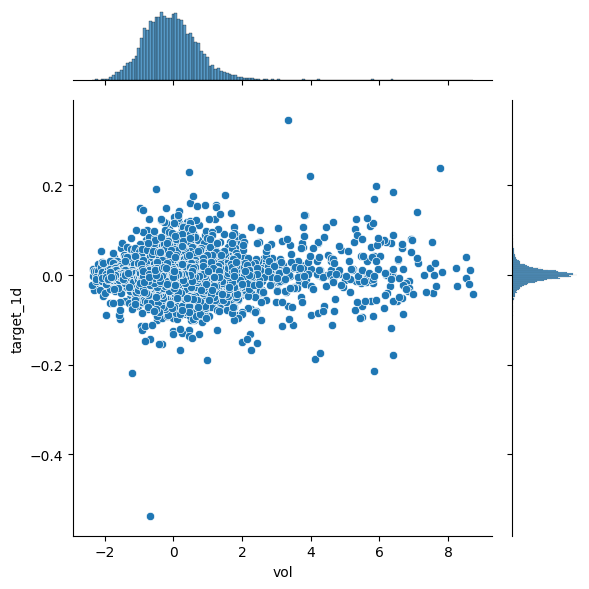

In [43]:
# use SNS to visualize how the one-day forward return is related to the normalized Parkinson volatility factor
target = "target_1d"
metric = "vol"
j = sns.jointplot(x=metric, y=target, data=prices)
plt.tight_layout()
df = prices[[metric, target]].dropna()
r, p = spearmanr(df[metric], df[target])

In [45]:
# computes the spearman rank order correlation coefficient between two data arrays
stat, pvalue = spearmanr(df[metric], df[target])